In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from evaluate import evaluate_thresholds
from plot import plot_comprehensive_results

In [2]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [3]:
def count_layers(model):
    """Count the number of layers in a model"""
    return len([name for name, param in model.named_parameters() if 'layer' in name])

def count_non_zero_params(model):
    """Count non-zero parameters in a model"""
    total_params = 0
    non_zero_params = 0
    
    for name, param in model.named_parameters():
        if param.requires_grad:
            total_params += param.numel()
            non_zero_params += (param.data != 0).sum().item()
    
    return non_zero_params, total_params

def estimate_flops(model, seq_length=128):
    """Estimate FLOPs for a transformer model"""
    config = model.config
    hidden_size = getattr(config, 'hidden_size', 768)
    num_layers = getattr(config, 'num_hidden_layers', 12)
    num_attention_heads = getattr(config, 'num_attention_heads', 12)
    
    # Estimate FLOPs for one forward pass
    # This is a simplified estimation
    flops_per_token = 0
    
    # Self-attention operations
    flops_per_token += 4 * num_layers * hidden_size * hidden_size  # Query, key, value, output projections
    flops_per_token += 2 * num_layers * seq_length * hidden_size  # QK attention
    
    # FFN operations
    ffn_dim = getattr(config, 'intermediate_size', 4 * hidden_size)
    flops_per_token += 2 * num_layers * hidden_size * ffn_dim  # Two linear layers in FFN
    
    # Multiply by sequence length
    total_flops = flops_per_token * seq_length
    
    # Adjust for sparsity
    non_zero_params, total_params = count_non_zero_params(model)
    sparsity_ratio = non_zero_params / total_params if total_params > 0 else 0
    
    # Adjust FLOPs based on sparsity (this is a simplification)
    adjusted_flops = total_flops * sparsity_ratio
    
    return adjusted_flops, total_flops

def disable_low_weight_neurons(model, threshold_percentage=0.5):
    """
    Disable low-weight neurons in a model and report metrics before and after.
    
    Args:
        model: The PyTorch model
        threshold_percentage: The percentage threshold for pruning (0-100)
        
    Returns:
        tuple: (modified model, metrics dictionary)
    """
    # Get original metrics
    original_number_of_layers = count_layers(model)
    original_non_zero_params, original_total_params = count_non_zero_params(model)
    original_flops_estimate, original_total_flops = estimate_flops(model)
    
    print(f"Original metrics:")
    print(f"Number of layers: {original_number_of_layers}")
    print(f"Parameters: {original_non_zero_params:,}/{original_total_params:,} ({original_non_zero_params/original_total_params*100:.2f}%)")
    print(f"Estimated FLOPs: {original_flops_estimate:,.0f}")
    
    # Disable low-weight neurons
    for name, param in model.named_parameters():
        if 'weight' in name and len(param.shape) > 1:
            max_weight = torch.abs(param.data).max().item()
            threshold = max_weight * (threshold_percentage / 100)
            
            mask = torch.abs(param.data) >= threshold
            param.data[~mask] = 0.0
    
    # Get metrics after pruning
    pruned_non_zero_params, pruned_total_params = count_non_zero_params(model)
    pruned_flops_estimate, pruned_total_flops = estimate_flops(model)
    
    print(f"\nAfter pruning (threshold: {threshold_percentage}%):")
    print(f"Parameters: {pruned_non_zero_params:,}/{pruned_total_params:,} ({pruned_non_zero_params/pruned_total_params*100:.2f}%)")
    print(f"Estimated FLOPs: {pruned_flops_estimate:,.0f}")
    print(f"Reduction in parameters: {(1 - pruned_non_zero_params/original_non_zero_params)*100:.2f}%")
    print(f"Reduction in FLOPs: {(1 - pruned_flops_estimate/original_flops_estimate)*100:.2f}%")
    
    return model, {
        "original": {
            "total_layers": original_number_of_layers,
            "non_zero_params": original_non_zero_params,
            "total_params": original_total_params,
            "flops_estimate": original_flops_estimate
        },
        "after_pruning": {
            "non_zero_params": pruned_non_zero_params,
            "total_params": pruned_total_params,
            "flops_estimate": pruned_flops_estimate,
            "params_reduction_percentage": (1 - pruned_non_zero_params/original_non_zero_params)*100,
            "flops_reduction_percentage": (1 - pruned_flops_estimate/original_flops_estimate)*100
        }
    }

In [4]:
import numpy as np
import pandas as pd
import torch
import copy
from scipy.special import softmax
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

def evaluate_model(model, tokenizer, validation_df):
    """
    Evaluate model with detailed metrics on the validation set
    Returns overall and class-specific metrics
    """
    predictions = []
    true_labels = []
    
    for index, row in validation_df.iterrows():
        text = row['text']
        true_label = row['label']
        
        text = preprocess(text)
        encoded_input = tokenizer(text, return_tensors='pt')
        output = model(**encoded_input)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)
        
        predicted_class = np.argmax(scores)
        predictions.append(predicted_class)
        true_labels.append(true_label)

    # Get unique classes from the dataset (dynamically)
    unique_classes = sorted(validation_df['label'].unique())
    class_names = {
        0: "ham",
        1: "spam", 
    }  # Mapping based on typical sentiment analysis. Adjust if needed.
    
    # Calculate overall metrics
    overall_accuracy = accuracy_score(true_labels, predictions)
    overall_f1 = f1_score(true_labels, predictions, average='weighted')
    overall_precision = precision_score(true_labels, predictions, average='weighted')
    overall_recall = recall_score(true_labels, predictions, average='weighted')
    
    # Calculate class-specific metrics
    metrics = {
        'overall_accuracy': overall_accuracy,
        'overall_f1': overall_f1,
        'overall_precision': overall_precision,
        'overall_recall': overall_recall
    }
    
    # Calculate confusion matrix for class-specific accuracy
    cm = confusion_matrix(true_labels, predictions)
    
    # For each class, calculate metrics
    for class_idx in unique_classes:
        class_name = class_names.get(class_idx, f"class_{class_idx}")
        
        # Class-specific accuracy from confusion matrix
        class_accuracy = cm[class_idx, class_idx] / np.sum(cm[class_idx, :]) if np.sum(cm[class_idx, :]) > 0 else 0
        
        # Other class-specific metrics
        class_f1 = f1_score(true_labels, predictions, labels=[class_idx], average='micro')
        class_precision = precision_score(true_labels, predictions, labels=[class_idx], average='micro')
        class_recall = recall_score(true_labels, predictions, labels=[class_idx], average='micro')
        
        # Store in metrics dictionary
        metrics[f'{class_name}_accuracy'] = class_accuracy
        metrics[f'{class_name}_f1'] = class_f1
        metrics[f'{class_name}_precision'] = class_precision
        metrics[f'{class_name}_recall'] = class_recall
    
    return metrics

def evaluate_thresholds(validation_path, thresholds, tokenizer, original_model):
    """
    Evaluate model performance across different pruning thresholds with detailed metrics
    
    Args:
        model_name: Name or path of the HuggingFace model
        validation_path: Path to the validation CSV
        thresholds: List of threshold percentages to evaluate
        tokenizer: The tokenizer to use
        original_model: The original model to prune
        
    Returns:
        DataFrame with results for each threshold including class-specific metrics
    """
    
    # Load validation data
    validation_df = pd.read_csv(validation_path)
    
    # Get baseline metrics
    baseline_metrics = evaluate_model(original_model, tokenizer, validation_df)
    baseline_params, total_params = count_non_zero_params(original_model)
    baseline_flops, total_flops = estimate_flops(original_model)
    
    # Prepare results storage
    results = {
        'threshold': [],
        'flops': [],
        'non_zero_params': [],
        'params_reduction_pct': [],
        'flops_reduction_pct': []
    }
    
    # Add all metric keys to results
    for key in baseline_metrics.keys():
        results[key] = []
    
    # Add baseline (threshold 0)
    results['threshold'].append(0)
    results['flops'].append(baseline_flops)
    results['non_zero_params'].append(baseline_params)
    results['params_reduction_pct'].append(0)
    results['flops_reduction_pct'].append(0)
    
    # Add baseline metrics
    for key, value in baseline_metrics.items():
        results[key].append(value)
    
    print(f"Baseline metrics:")
    print(f"Overall accuracy: {baseline_metrics['overall_accuracy']:.4f}")
    print(f"Baseline params: {baseline_params:,}/{total_params:,}")
    print(f"Baseline FLOPs: {baseline_flops:,.0f}")
    
    # Evaluate each threshold
    for threshold in thresholds[1:]:  # Skip 0 as it's our baseline
        print(f"\nEvaluating threshold: {threshold}%")
        
        # Create a fresh copy of the model for this threshold
        model_copy = copy.deepcopy(original_model)
        
        # Apply pruning
        pruned_model, metrics = disable_low_weight_neurons(model_copy, threshold_percentage=threshold)
        
        # Evaluate with detailed metrics
        evaluation_metrics = evaluate_model(pruned_model, tokenizer, validation_df)
        
        # Store threshold and pruning metrics
        results['threshold'].append(threshold)
        results['flops'].append(metrics['after_pruning']['flops_estimate'])
        results['non_zero_params'].append(metrics['after_pruning']['non_zero_params'])
        results['params_reduction_pct'].append(metrics['after_pruning']['params_reduction_percentage'])
        results['flops_reduction_pct'].append(metrics['after_pruning']['flops_reduction_percentage'])
        
        # Store all evaluation metrics
        for key, value in evaluation_metrics.items():
            results[key].append(value)
        
        print(f"Overall accuracy: {evaluation_metrics['overall_accuracy']:.4f}")
        print(f"Params: {metrics['after_pruning']['non_zero_params']:,}/{metrics['original']['total_params']:,} " +
              f"(Reduction: {metrics['after_pruning']['params_reduction_percentage']:.2f}%)")
        print(f"FLOPs: {metrics['after_pruning']['flops_estimate']:,.0f} " +
              f"(Reduction: {metrics['after_pruning']['flops_reduction_percentage']:.2f}%)")
        
        # Free memory
        del model_copy
        del pruned_model
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def plot_comprehensive_results(results_df, save_prefix=None):
    """
    Plot comprehensive evaluation results including:
    1. Overall and class-specific accuracy
    2. FLOPs and FLOPs reduction
    3. Class-specific F1 scores
    
    Args:
        results_df: DataFrame containing evaluation results
        save_prefix: If provided, plots will be saved with this prefix
    """
    # Create a 2x1 figure layout (accuracy and F1 charts stacked vertically)
    fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(16, 16))
    
    # Plot overall accuracy on the top plot
    ax1.plot(results_df['threshold'], results_df['overall_accuracy'], 
             marker='o', linewidth=2.5, label='Overall Accuracy', color='blue')
    
    # Identify and plot class-specific accuracies
    class_columns = [col for col in results_df.columns if col.endswith('_accuracy') and col != 'overall_accuracy']
    class_colors = {'negative_accuracy': 'red', 'neutral_accuracy': 'green', 'positive_accuracy': 'purple'}
    
    for col in class_columns:
        class_name = col.split('_')[0]
        color = class_colors.get(col, None)  # Use predefined color or None (matplotlib will choose)
        ax1.plot(results_df['threshold'], results_df[col], 
                marker='s', linewidth=2, label=f'{class_name.capitalize()} Accuracy', color=color)
    
    ax1.set_title('Model Accuracy vs Pruning Threshold', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Pruning Threshold (%)', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.set_xticks(results_df['threshold'])
    ax1.set_ylim([0, 1.05])  # Set y-axis from 0 to just above 1
    ax1.legend(loc='best', fontsize=11)
    
    # Plot class-specific F1 scores on the bottom plot
    ax3.plot(results_df['threshold'], results_df['overall_f1'], 
             marker='o', linewidth=2.5, label='Overall F1', color='blue')
    
    # Plot class-specific F1 scores
    f1_columns = [col for col in results_df.columns if col.endswith('_f1') and col != 'overall_f1']
    class_colors = {'negative_f1': 'red', 'neutral_f1': 'green', 'positive_f1': 'purple'}
    
    for col in f1_columns:
        class_name = col.split('_')[0]
        color = class_colors.get(col, None)
        ax3.plot(results_df['threshold'], results_df[col], 
                marker='s', linewidth=2, label=f'{class_name.capitalize()} F1', color=color)
    
    ax3.set_title('F1 Scores vs Pruning Threshold', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Pruning Threshold (%)', fontsize=12)
    ax3.set_ylabel('F1 Score', fontsize=12)
    ax3.grid(True, linestyle='--', alpha=0.7)
    ax3.set_xticks(results_df['threshold'])
    ax3.set_ylim([0, 1.05])
    ax3.legend(loc='best', fontsize=11)
    
    plt.tight_layout()
    if save_prefix:
        plt.savefig(f"{save_prefix}_metrics.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Figure 2: FLOPs reduction as a separate chart
    fig2, ax2 = plt.subplots(figsize=(16, 8))
    
    # Plot FLOPs reduction percentage
    ax2.plot(results_df['threshold'], results_df['flops_reduction_pct'], 
             marker='o', color='orange', linewidth=2.5, label='FLOPs Reduction %')
    ax2.set_title('FLOPs Reduction vs Pruning Threshold', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Pruning Threshold (%)', fontsize=12)
    ax2.set_ylabel('FLOPs Reduction (%)', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.set_xticks(results_df['threshold'])
    
    plt.tight_layout()
    if save_prefix:
        plt.savefig(f"{save_prefix}_flops_reduction.png", dpi=300, bbox_inches='tight')
    plt.show()

In [6]:
VALIDATION_PATH = "datasets/sentiment/kaggle/spam/spam_test.csv"

tokenizer = AutoTokenizer.from_pretrained("AntiSpamInstitute/spam-detector-bert-MoE-v2.2")
original_model = AutoModelForSequenceClassification.from_pretrained("AntiSpamInstitute/spam-detector-bert-MoE-v2.2")

# Define thresholds to evaluate (0 to 5 in steps of 0.1)
thresholds = [i * 0.1 for i in range(0, 31)]  # 0% to 3% in steps of 0.1%

# Run evaluation
results = evaluate_thresholds(VALIDATION_PATH, thresholds, tokenizer, original_model)

tokenizer_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

Baseline metrics:
Overall accuracy: 0.9900
Baseline params: 4,386,178/4,386,178
Baseline FLOPs: 58,720,256

Evaluating threshold: 0.1%
Original metrics:
Number of layers: 32
Parameters: 4,386,178/4,386,178 (100.00%)
Estimated FLOPs: 58,720,256

After pruning (threshold: 0.1%):
Parameters: 4,346,821/4,386,178 (99.10%)
Estimated FLOPs: 58,193,361
Reduction in parameters: 0.90%
Reduction in FLOPs: 0.90%
Overall accuracy: 0.9900
Params: 4,346,821/4,386,178 (Reduction: 0.90%)
FLOPs: 58,193,361 (Reduction: 0.90%)

Evaluating threshold: 0.2%
Original metrics:
Number of layers: 32
Parameters: 4,386,178/4,386,178 (100.00%)
Estimated FLOPs: 58,720,256

After pruning (threshold: 0.2%):
Parameters: 4,307,862/4,386,178 (98.21%)
Estimated FLOPs: 57,671,795
Reduction in parameters: 1.79%
Reduction in FLOPs: 1.79%
Overall accuracy: 0.9900
Params: 4,307,862/4,386,178 (Reduction: 1.79%)
FLOPs: 57,671,795 (Reduction: 1.79%)

Evaluating threshold: 0.30000000000000004%
Original metrics:
Number of layers: 3

In [7]:
# Save results to CSV
results.to_csv("runs/spam_detection_2/pruning_threshold_results.csv", index=False)

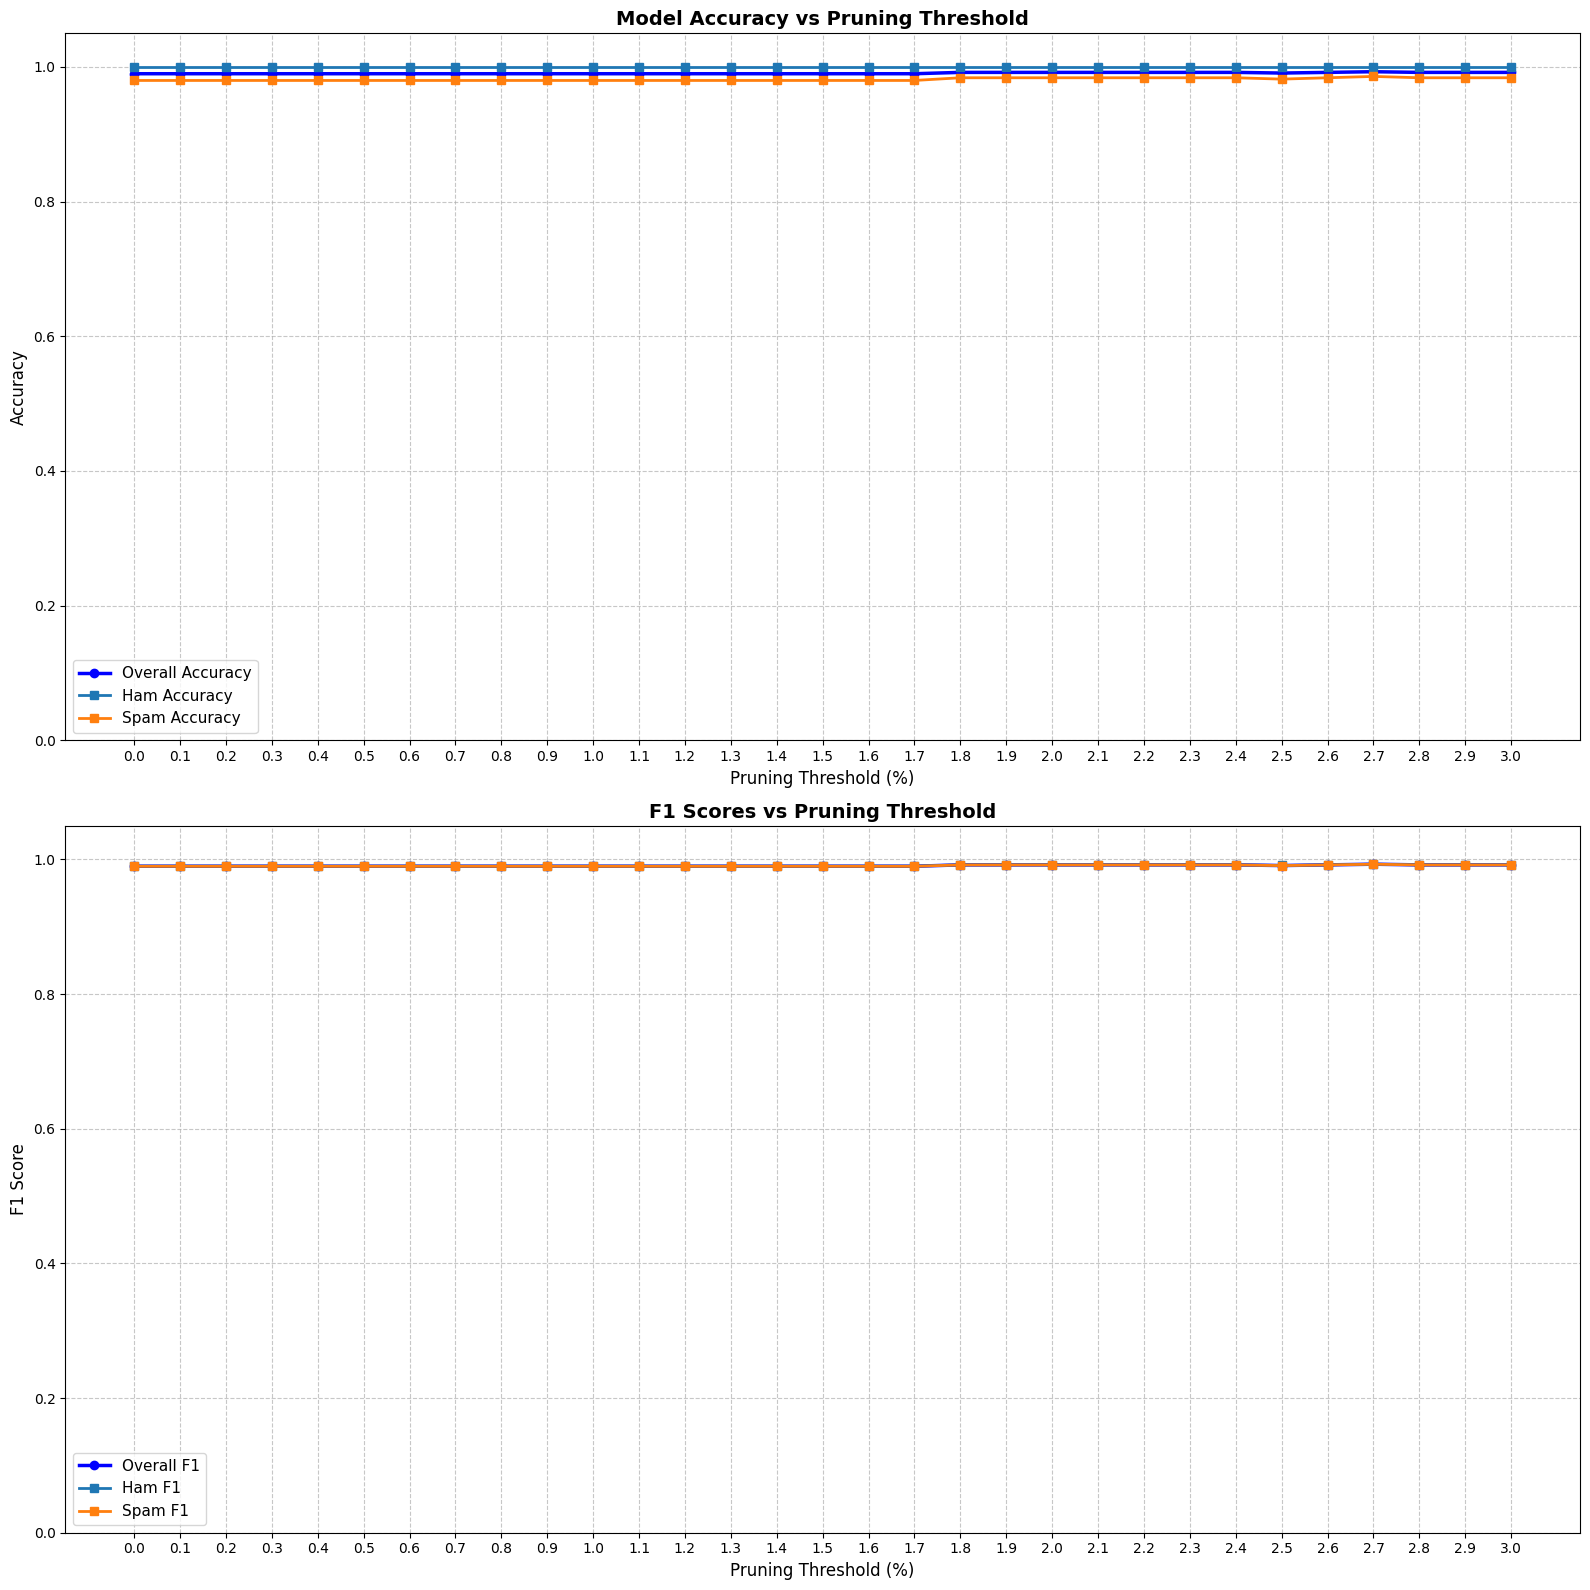

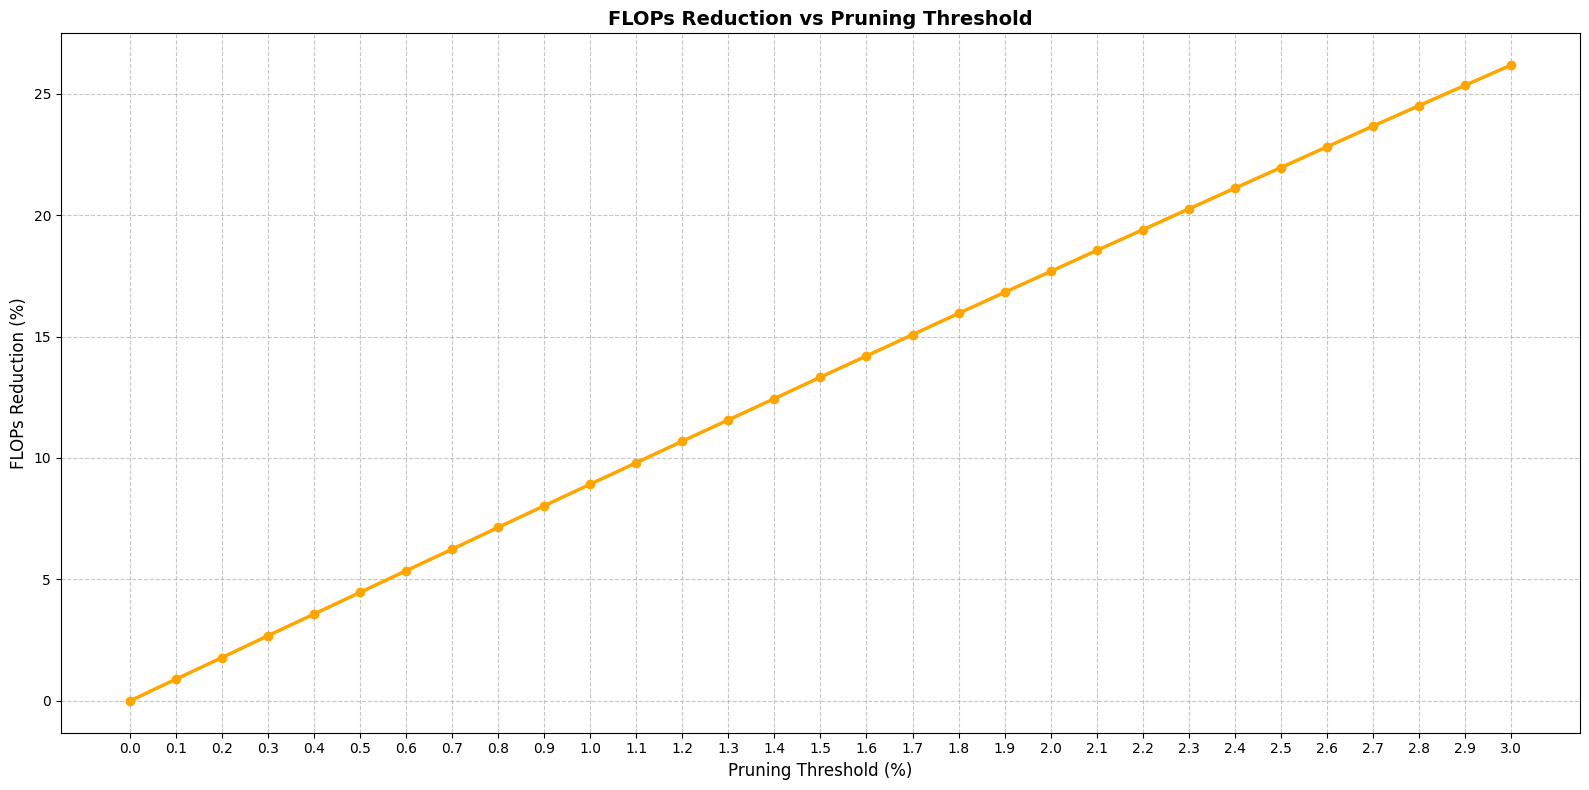

In [8]:
plot_comprehensive_results(results, save_prefix="spam_detection")